In [1]:
# Added Libs
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
# import packages and read in full dataset (pca features)
from read_data import get_all_data, split_and_stratify_data, get_balanced_df

import warnings
warnings.filterwarnings('ignore') # for looks..

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, log_loss, matthews_corrcoef
import scikitplot as skplt

full_dataset = get_all_data(number_of_pca_features = 100)
full_dataset.head()

GroundTruth.csv read. Processing/searching for image data. May take a few minutes if process_images_again == True.

Existing image data read..
Here is the cumulative variance explained by the top n principal components..
[0.31257716 0.54008686 0.66481299 0.7057795  0.74346465 0.77956174
 0.80114615 0.81924822 0.83539777 0.8507423  0.86424108 0.8750329
 0.88251965 0.88884104 0.89510091 0.90050337 0.90577069 0.91083161
 0.91540637 0.91968503 0.92259132 0.92535737 0.92803304 0.93063927
 0.93311294 0.93549835 0.93778653 0.93980628 0.94179666 0.94344428
 0.94486636 0.94619368 0.94750187 0.94877141 0.95000678 0.95122232
 0.95237959 0.9534572  0.95452557 0.95557189 0.95661161 0.95758342
 0.95852778 0.95936875 0.96019455 0.96099447 0.96176479 0.96252313
 0.96324924 0.9639561  0.96464723 0.96529059 0.96592324 0.9665458
 0.96711326 0.96765529 0.96819545 0.96870674 0.96921178 0.96970669
 0.97018163 0.97064448 0.97110586 0.97154421 0.971972   0.97238688
 0.97279964 0.97319277 0.97357719 0.97395033

,image,cancer_type,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,ISIC_0024306.jpg,NV,2.227468,-3.264277,-1.167765,0.924474,-2.286435,1.804567,0.273134,0.418798,...,-0.099027,-0.009333,-0.051041,-0.019836,-0.134981,0.083766,0.020061,-0.062348,-0.155223,-0.037895
1,ISIC_0024307.jpg,NV,1.068419,-1.742836,-2.110399,0.040784,-1.148290,0.792414,0.011848,0.533355,...,-0.039695,-0.032529,0.015959,-0.021628,-0.059418,-0.019899,0.006778,0.107662,-0.039652,-0.009560
2,ISIC_0024308.jpg,NV,0.983078,-4.920764,0.617789,1.684504,-0.617451,-0.853629,-0.934357,0.139916,...,0.103498,0.018952,0.015636,0.057682,0.015973,0.040700,0.187303,-0.050769,0.090087,0.106535
3,ISIC_0024309.jpg,NV,4.042187,-1.004445,-1.730627,0.354093,0.451159,-2.407673,0.339228,-0.318631,...,-0.080027,-0.027284,0.011457,0.087806,-0.070773,-0.000180,-0.049357,0.022274,0.046849,-0.057677
4,ISIC_0024310.jpg,MEL,0.925909,-0.801578,-0.337978,1.529686,-0.320369,0.183890,-0.863793,0.924670,...,0.221153,0.113545,0.000518,0.071552,0.341293,-0.269370,0.305026,-0.021116,0.292971,0.065647


In [3]:
# split into train test and validation datasets
train, test, validate = split_and_stratify_data(full_dataset, random = 1)

# balance the training set?
#train = get_balanced_df(train, val_size = 1000, col = 'cancer_type')

# create X and y train, test and validate sets
X_train = train.iloc[:,2:-1]
X_test = test.iloc[:,2:-1]
X_validate = validate.iloc[:,2:-1]

y_train = train.iloc[:,1]
y_test = test.iloc[:,1]
y_validate = validate.iloc[:,1]

# over samples the under-represented classes - seems to have improved random forest, maybe svm a little, hurt all other models
sm = SMOTE(random_state=2)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print('Training Set Cancer Counts')
print(y_train.value_counts())
print('Test Set Cancer Counts')
print(y_test.value_counts())
print('Validation Set Cancer Counts')
print(y_validate.value_counts())

Training Set Cancer Counts
NV       5364
MEL       890
BKL       879
BCC       411
AKIEC     262
VASC      114
DF         92
Name: cancer_type, dtype: int64
Test Set Cancer Counts
NV       670
MEL      111
BKL      110
BCC       51
AKIEC     33
VASC      14
DF        12
Name: cancer_type, dtype: int64
Validation Set Cancer Counts
NV       671
MEL      112
BKL      110
BCC       52
AKIEC     32
VASC      14
DF        11
Name: cancer_type, dtype: int64


In [4]:
# function for evaluating a classification model

def evaluate_model(model, y_test, X_test):

    y_pred = model.predict(X_test)
    y_probas = model.predict_proba(X_test)

    print(f'Model Accuracy is {round(accuracy_score(y_test, y_pred),4)*100}%')
    print(f'Log loss of the model is {round(log_loss(y_test, y_probas), 3)}')
    print(f'Matthews Correlation Coefficient is {round(matthews_corrcoef(y_test, y_pred),3)}')
    print('\nHere is the classification report. \n')
    print(classification_report(y_test, y_pred))

    print('Confusion Matrix is here:\n')
    plot_confusion_matrix(model, X_test, y_test)  
    plt.show() 

    print('Here are the ROC Curves: \n')
    skplt.metrics.plot_roc_curve(y_test, y_probas)
    plt.show()
    

## MLPClassifier Model

Model Accuracy is 70.06%
Log loss of the model is 1.135
Matthews Correlation Coefficient is 0.398

Here is the classification report. 

              precision    recall  f1-score   support

       AKIEC       0.38      0.34      0.36        32
         BCC       0.42      0.38      0.40        52
         BKL       0.48      0.42      0.45       110
          DF       0.00      0.00      0.00        11
         MEL       0.31      0.28      0.29       112
          NV       0.82      0.88      0.85       671
        VASC       0.23      0.21      0.22        14

    accuracy                           0.70      1002
   macro avg       0.38      0.36      0.37      1002
weighted avg       0.68      0.70      0.69      1002

Confusion Matrix is here:



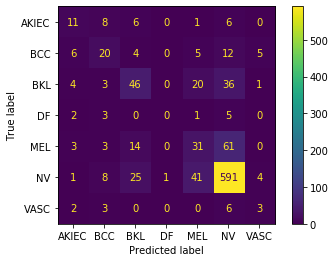

Here are the ROC Curves: 



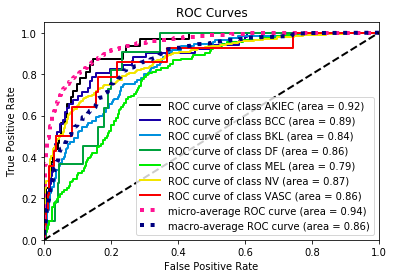

In [5]:
mlp_model = MLPClassifier(hidden_layer_sizes=(20,10), max_iter=500)
mlp_model.fit(X_train, y_train)

evaluate_model(model=mlp_model, y_test=y_validate, X_test=X_validate)

## XGBoost Model

[15:27:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Accuracy is 74.65%
Log loss of the model is 0.805
Matthews Correlation Coefficient is 0.439

Here is the classification report. 

              precision    recall  f1-score   support

       AKIEC       0.38      0.16      0.22        32
         BCC       0.50      0.37      0.42        52
         BKL       0.63      0.35      0.45       110
          DF       0.00      0.00      0.00        11
         MEL       0.57      0.25      0.35       112
          NV       0.78      0.98      0.87       671
        VASC       1.00      0.07      0.13        14

    accuracy                           0.75      1002
   macro avg       0.55      0.31      0.35      1002
weighted avg       0.71      0.75      

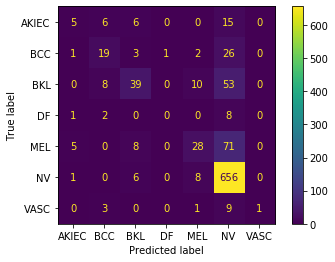

Here are the ROC Curves: 



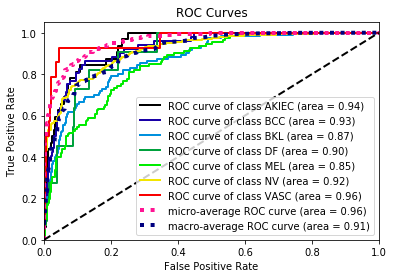

In [6]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

evaluate_model(model = xgb_model, y_test = y_validate, X_test = X_validate)

## Tensflow Model

In [8]:
classes = list(set(y_train))
class_dict = {classes[i]:i for i in range(len(classes))}
y_train2 = np.array([class_dict[i] for i in y_train.to_numpy()])
y_validate2 = np.array([class_dict[i] for i in y_validate.to_numpy()])
y_test2 = np.array([class_dict[i] for i in y_test.to_numpy()])


def run_tensflow_model1():
    tf_model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(99, )),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10)
    ])

    tf_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    tf_model.fit(X_train.to_numpy(), y_train2, epochs=12) 

    #evaluate_model(model = tf_model, y_test = y_validate2, X_test = X_validate.to_numpy())
    test_loss, test_acc = tf_model.evaluate(X_validate.to_numpy(),  y_validate2, verbose=2)
    print('\nTest accuracy:', test_acc)
    
    predictions = tf_model.predict(X_test.to_numpy())
    return predictions


def run_tensflow_model2():
    num_classes = 7

    tf_model = Sequential([
      layers.Conv2D(33, (99,1), padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(33, (99,1), padding='same', activation='relu'),
      layers.MaxPooling2D(),
      #layers.Conv2D(99, 1, padding='same', activation='relu'),
      #layers.MaxPooling2D(),
      layers.Flatten(),
      #layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
    ])
    
    tf_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    tf_model.fit(X_train.to_numpy(), y_train2, epochs=12) 

    #evaluate_model(model = tf_model, y_test = y_validate2, X_test = X_validate.to_numpy())
    test_loss, test_acc = tf_model.evaluate(X_validate.to_numpy(),  y_validate2, verbose=2)
    print('\nTest accuracy:', test_acc)    
    
    predictions = tf_model.predict(X_test.to_numpy())
    return predictions    
    
    
    

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

Epoch 1/12
251/251 [==============================] - 1s 843us/step - loss: 1.0895 - accuracy: 0.6474
Epoch 2/12
251/251 [==============================] - 0s 926us/step - loss: 0.7929 - accuracy: 0.7119
Epoch 3/12
251/251 [==============================] - 0s 989us/step - loss: 0.7358 - accuracy: 0.7290
Epoch 4/12
251/251 [==============================] - 0s 948us/step - loss: 0.6943 - accuracy: 0.7400
Epoch 5/12
251/251 [==============================] - 0s 853us/step - loss: 0.6629 - accuracy: 0.7515
Epoch 6/12
251/251 [==============================] - 0s 962us/step - loss: 0.6348 - accuracy: 0.7652
Epoch 7/12
251/251 [==============================] - 0s 987us/step - loss: 0.6121 - accuracy: 0.7706
Epoch 8/12
251/251 [==============================] - 0s 1ms/step - loss: 0.5911 - accuracy: 0.7802
Epoch 9/12
251/251 [==============================] - 0s 1ms/step - loss: 0.5714 - accuracy: 0.7869
Epoch 10/12
251/251 [==============================] - 0s 983us/step - loss: 0.5523 - 

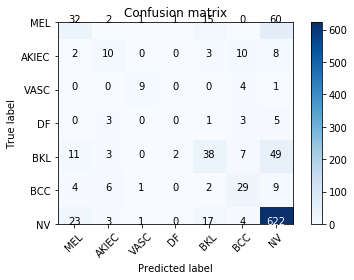

In [9]:
preds1 = run_tensflow_model1()

cm1 = confusion_matrix(y_test2, preds1.argmax(axis=1))
plot_confusion_matrix(cm1, classes)